In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [3]:
def N(x,mu,sigma): #normal distribution
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

In [4]:
def likelihood_ratio(x1,x2): #return pre-specifed likelihood ratio
    return (0.5*(N(x1,-1,1)+N(x1,1,1))*0.5*(N(x2,-1,1)+N(x2,1,1)))/(N(x1,0,1)*N(x2,0,1))

In [142]:
f0_train = np.random.normal(0, 1, 400).reshape(-1,2)
#f1_train = np.random.normal(-2, 1, 400).reshape(-1,2)
f1_train = np.array([np.random.choice([np.random.normal(-1, 1),np.random.normal(1, 1)]) for i in range(400)]).reshape(-1,2)

f0_test = np.random.normal(0, 1, 2000000).reshape(-1,2)
#f1_test = np.random.normal(-2, 1, 2000000).reshape(-1,2)
f1_test = np.array([np.random.choice([np.random.normal(-1, 1),np.random.normal(1, 1)]) for i in range(2000000)]).reshape(-1,2)

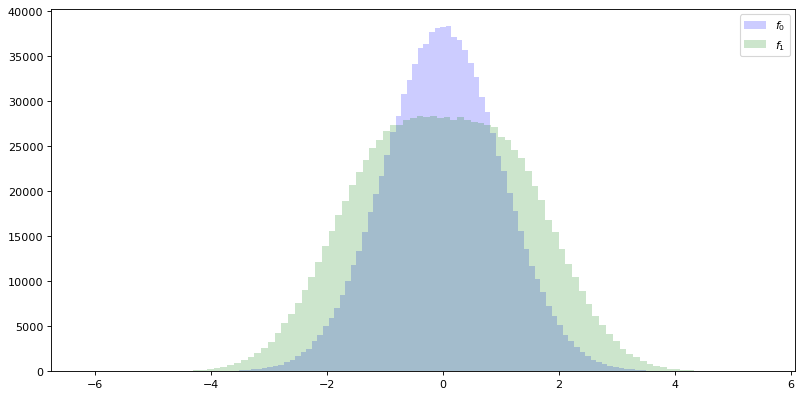

In [45]:
plt.figure(figsize=(12, 6), dpi=80)
plt.hist(f0_test[:,0], bins=100, edgecolor='None', alpha = 0.2, color= 'b', label='$f_{0}(x)$')
plt.hist(f1_test[:,0], bins=100, edgecolor='None', alpha = 0.2, color= 'g', label='$f_{1}(x)$')
plt.legend()

Bayesian test

In [52]:
type1 = np.sum(likelihood_ratio(f0_test[:,0],f0_test[:,1])>1) #H0 rejected even though samples drawn from f0
type2 = np.sum(likelihood_ratio(f1_test[:,0],f1_test[:,1])<1) #H1 rejected even though samples drawn from f1

print((type1 + type2)/2000000)

0.352788


In [76]:
def ROCandReport(likelihood_ratios, true, description):
    preds = likelihood_ratios/(likelihood_ratios+1) #from likelihood ratios to probabilities
    fpr1, tpr1, thresh1 = roc_curve(true, preds, pos_label=1, drop_intermediate=False) #roc curve
    plt.plot(fpr1, tpr1, label=description) #plot ROC
    print(classification_report(true, preds>0.5, target_names=['f0','f1'], digits=4)) #classification report, errors per class etc

In [74]:
test_set =  np.concatenate((f0_test,f1_test))
true = np.concatenate((np.zeros(1000000),np.ones(1000000)))

In [8]:
likelihood_ratios = likelihood_ratio(test_set[:,0],test_set[:,1])

              precision    recall  f1-score   support

          f0       0.63      0.72      0.67   1000000
          f1       0.67      0.58      0.62   1000000

    accuracy                           0.65   2000000
   macro avg       0.65      0.65      0.65   2000000
weighted avg       0.65      0.65      0.65   2000000



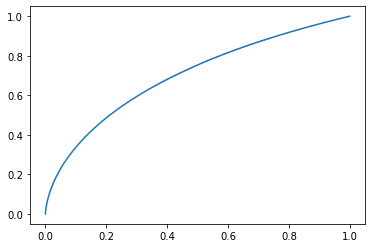

In [11]:
ROC(likelihood_ratios, true, 'bayesian test')

In [45]:
1 - np.sum(((preds>0.5)*1)==true)/2000000

0.35329999999999995

$NN$

In [13]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

In [14]:
class FC(nn.Module): #Fully connected network
    def __init__(self,input_size, hidden_number,hidden_size): 
        super(FC, self).__init__()
        self.sig = nn.Sigmoid()
        self.inLayer = nn.Linear(input_size, hidden_size) #input layer of specified input size
        self.linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(hidden_number)]) #hidden_number number of hidden layers
        self.outLayer = nn.Linear(hidden_size, 1) #output layer

    def forward(self, x, criterion='BCE'): #forward method
        x = self.inLayer(x) #feed input through the input layer
        
        for i, layer in enumerate(self.linears): #feed input layer output through each hidden layer
            x = torch.relu(x) #and apply relu activation
            x = layer(x) 
  
        x = torch.relu(x)
        x = self.outLayer(x) #feed hidden output through output layer
        
        if criterion == 'BCE': #if method is binary cross entropy
            x = self.sig(x) #apply sigmoid activation to bound output between (0,1)

        return x

In [147]:
def train(f0_train, f1_train, f0_test, f1_test, epochs, learning_rate, input_size, hidden_layers, hidden_size, criterion = 'BCE'):
    
    X_train = np.concatenate((f0_train, f1_train)) #combine classes arrays into a training data array
    X_train = torch.tensor(X_train).type(torch.FloatTensor) #convert to tensor
    
    NN = FC(input_size,hidden_layers-1,hidden_size) #initialize NN
    optimizer = torch.optim.SGD(NN.parameters() ,lr=learning_rate) #specify optimizer, SGD in our case
    
    test_error_history = [] #arrays that will contain the error history
    train_error_history = []
    
    for epoch in range(epochs): #in each epoch
        X = X_train.clone() #get a copy of the training data
        u = NN(X, criterion) #use training data as NN input and get the output
        
        #get the error depending on the method
        if criterion == 'BCE':
            loss = torch.mean(-torch.log(1-u[:len(f0_train)])) + torch.mean(-torch.log(u[len(f0_train):]))
        elif criterion == 'exp':
            loss = torch.mean(torch.exp(0.5*u[:len(f0_train)])) + torch.mean(torch.exp(-0.5*u[len(f0_train):]))
        elif criterion == 'hinge':
            loss = torch.mean(torch.max(1+u[:len(f0_train)],torch.tensor(0))) + torch.mean(torch.max(1-u[len(f0_train):],torch.tensor(0)))
            
        optimizer.zero_grad() #clear previous values in the computation graph
        loss.backward() #calculates loss gradients wrt NN parameters
        optimizer.step() #apply a SGD step

        if (epoch+1) % 1000 == 0: #progress tracking
            threshold = len(f0_train)/len(f1_train) #calculate the threshold as P(H0)/P(H1)
            test_error = classification_error(f0_test,f1_test, threshold, NN, method=criterion) #calculate the classification error on test data
            train_error = classification_error(f0_train,f1_train, threshold, NN, method=criterion) #calculate the classification error on train data
            test_error_history.append(test_error) #append both errors to error history arrays
            train_error_history.append(train_error)
            
            print("Epoch: {}, Loss: {:.7f}, Test Error: {:.4f}, Train Error: {:.4f}".format((epoch+1), loss, test_error, train_error))       
    
    plt.plot(test_error_history, label='test set classification error') #when training is over plot test error history
    #plt.plot(train_error_history, label='train set classification error')
    plt.legend()
    
    return NN, test_error_history

In [17]:
def classification_error(class_1, class_2, threshold, NN, method = 'BCE'):
    with torch.no_grad(): #do not include these operations in the computation graph
        x = np.concatenate((class_1, class_2)) #data preprocessing
        X = torch.tensor(x).type(torch.FloatTensor)
        u = NN(X, method) #feed data to NN
        
        #depending on the desired method, calculate the threshold, and use that threshold to find the number of missclassifed data samples
        if method == 'BCE':
            threshold = threshold/(threshold+1)
            errors = torch.sum(u[:len(class_1)]>threshold)+torch.sum(u[len(class_1):]<threshold)
        elif method == 'exp':
            threshold = np.log(threshold)
            errors = torch.sum(u[:len(class_1)]>threshold)+torch.sum(u[len(class_1):]<threshold)
        elif method == 'hinge':
            threshold = np.sign(np.log(threshold))
            errors = torch.sum(u[:len(class_1)]>threshold)+torch.sum(u[len(class_1):]<threshold)
            
        return errors/len(X) #return error percentage

Epoch: 1000, Loss: 1.3585347, Test Error: 0.5000, Train Error: 0.5000
Epoch: 2000, Loss: 1.3430791, Test Error: 0.4824, Train Error: 0.4850
Epoch: 3000, Loss: 1.3319657, Test Error: 0.4219, Train Error: 0.4050
Epoch: 4000, Loss: 1.3230944, Test Error: 0.4092, Train Error: 0.3975
Epoch: 5000, Loss: 1.3155874, Test Error: 0.4020, Train Error: 0.3775
Epoch: 6000, Loss: 1.3090290, Test Error: 0.3971, Train Error: 0.3825
Epoch: 7000, Loss: 1.3031565, Test Error: 0.3936, Train Error: 0.3750
Epoch: 8000, Loss: 1.2978128, Test Error: 0.3907, Train Error: 0.3700
Epoch: 9000, Loss: 1.2928917, Test Error: 0.3883, Train Error: 0.3700
Epoch: 10000, Loss: 1.2883263, Test Error: 0.3861, Train Error: 0.3700
Epoch: 11000, Loss: 1.2840741, Test Error: 0.3840, Train Error: 0.3700
Epoch: 12000, Loss: 1.2801121, Test Error: 0.3821, Train Error: 0.3700
Epoch: 13000, Loss: 1.2763953, Test Error: 0.3804, Train Error: 0.3675
Epoch: 14000, Loss: 1.2728857, Test Error: 0.3788, Train Error: 0.3700
Epoch: 15000, L

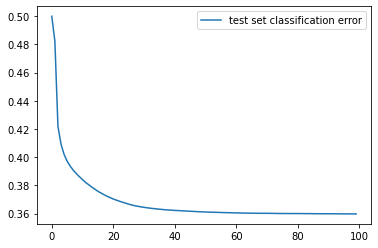

In [148]:
LR = 5e-4
epochs = 100000
hidden_layers = 1
hidden_size = 20
NN1, history1 = train(f0_train, f1_train, f0_test, f1_test, epochs, LR,2, hidden_layers, hidden_size, criterion = 'BCE')

Epoch: 1000, Loss: 1.9698431, Test Error: 0.4704, Train Error: 0.4200
Epoch: 2000, Loss: 1.9502709, Test Error: 0.4350, Train Error: 0.3950
Epoch: 3000, Loss: 1.9398344, Test Error: 0.4096, Train Error: 0.3575
Epoch: 4000, Loss: 1.9310516, Test Error: 0.3990, Train Error: 0.3425
Epoch: 5000, Loss: 1.9229209, Test Error: 0.3924, Train Error: 0.3275
Epoch: 6000, Loss: 1.9151522, Test Error: 0.3871, Train Error: 0.3250
Epoch: 7000, Loss: 1.9076979, Test Error: 0.3828, Train Error: 0.3250
Epoch: 8000, Loss: 1.9005580, Test Error: 0.3791, Train Error: 0.3200
Epoch: 9000, Loss: 1.8936617, Test Error: 0.3763, Train Error: 0.3200
Epoch: 10000, Loss: 1.8869832, Test Error: 0.3738, Train Error: 0.3175
Epoch: 11000, Loss: 1.8804992, Test Error: 0.3719, Train Error: 0.3200
Epoch: 12000, Loss: 1.8743259, Test Error: 0.3703, Train Error: 0.3125
Epoch: 13000, Loss: 1.8683643, Test Error: 0.3690, Train Error: 0.3125
Epoch: 14000, Loss: 1.8627024, Test Error: 0.3678, Train Error: 0.3125
Epoch: 15000, L

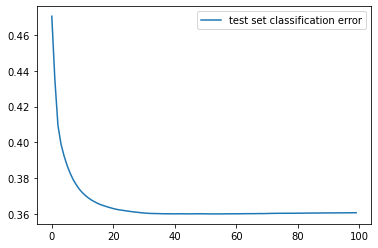

In [64]:
LR = 5e-4
epochs = 100000
hidden_layers = 1
hidden_size = 20
NN2, history2 = train(f0_train, f1_train, f0_test, f1_test, epochs, LR,2, hidden_layers, hidden_size, criterion = 'exp')

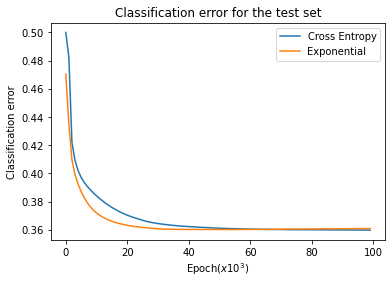

In [149]:
fig, ax = plt.subplots()

ax.plot(history1, label='Cross Entropy')
ax.plot(history2, label='Exponential')
ax.set(xlabel='Epoch($x10^{3}$)', ylabel='Classification error',
       title='Classification error for the test set')
ax.legend()

In [67]:
#u = r/(1+r) =>  u = 1 - 1/(1+r) => r+1 = 1/(1-u) => r = u/(1-u)
test_set =  np.concatenate((f0_test,f1_test)) #preprocess test data
test_set = torch.tensor(test_set).type(torch.FloatTensor)
u = NN1(test_set,'BCE') #feed through neural network
r = u/(1-u) #get theinverse transformation of the likelihood ratio transformation

In [68]:
u = NN2(test_set,'exp')
r2 = torch.exp(u)

              precision    recall  f1-score   support

          f0     0.6290    0.7180    0.6705   1000000
          f1     0.6715    0.5764    0.6203   1000000

    accuracy                         0.6472   2000000
   macro avg     0.6502    0.6472    0.6454   2000000
weighted avg     0.6502    0.6472    0.6454   2000000

              precision    recall  f1-score   support

          f0     0.6285    0.6752    0.6510   1000000
          f1     0.6491    0.6008    0.6240   1000000

    accuracy                         0.6380   2000000
   macro avg     0.6388    0.6380    0.6375   2000000
weighted avg     0.6388    0.6380    0.6375   2000000

              precision    recall  f1-score   support

          f0     0.6288    0.6794    0.6532   1000000
          f1     0.6514    0.5989    0.6241   1000000

    accuracy                         0.6392   2000000
   macro avg     0.6401    0.6392    0.6386   2000000
weighted avg     0.6401    0.6392    0.6386   2000000



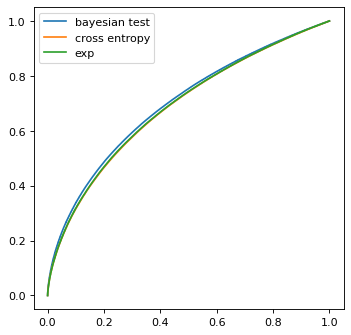

In [77]:
plt.figure(figsize=(5, 5), dpi=80)

ROCandReport(likelihood_ratios, true, 'bayesian test')
ROCandReport(r.detach().numpy() , true, 'cross entropy')
ROCandReport(r2.detach().numpy() , true, 'exp')
plt.legend()

$MNIST$

In [78]:
from torchvision import datasets, transforms

In [79]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)

testset = datasets.MNIST('test', download=True, train=False, transform=transform)

In [80]:
idx = (trainset.targets==0) | (trainset.targets==8)
y_train = trainset.targets[idx]
X_train = trainset.data[idx]

idx = (testset.targets==0) | (testset.targets==8)
y_test = testset.targets[idx]
X_test = testset.data[idx]

In [81]:
f0_train = X_train[(y_train==0).nonzero()]
f0_train = f0_train.reshape(len(f0_train),-1)/255

f1_train = X_train[(y_train==8).nonzero()]
f1_train = f1_train.reshape(len(f1_train),-1)/255

f0_test = X_test[(y_test==0).nonzero()]
f0_test = f0_test.reshape(len(f0_test),-1)/255

f1_test = X_test[(y_test==8).nonzero()]
f1_test = f1_test.reshape(len(f1_test),-1)/255

Epoch: 1, Loss: 1.9824512, Test Error: 0.1576, Train Error: 0.1691
Epoch: 2, Loss: 1.9091566, Test Error: 0.0798, Train Error: 0.0880
Epoch: 3, Loss: 1.8393946, Test Error: 0.0542, Train Error: 0.0616
Epoch: 4, Loss: 1.7690260, Test Error: 0.0445, Train Error: 0.0471
Epoch: 5, Loss: 1.6960802, Test Error: 0.0379, Train Error: 0.0398
Epoch: 6, Loss: 1.6198196, Test Error: 0.0317, Train Error: 0.0366
Epoch: 7, Loss: 1.5403736, Test Error: 0.0271, Train Error: 0.0342
Epoch: 8, Loss: 1.4584725, Test Error: 0.0276, Train Error: 0.0329
Epoch: 9, Loss: 1.3752360, Test Error: 0.0261, Train Error: 0.0311
Epoch: 10, Loss: 1.2921076, Test Error: 0.0251, Train Error: 0.0303
Epoch: 11, Loss: 1.2105639, Test Error: 0.0235, Train Error: 0.0296
Epoch: 12, Loss: 1.1319101, Test Error: 0.0225, Train Error: 0.0296
Epoch: 13, Loss: 1.0572407, Test Error: 0.0215, Train Error: 0.0294
Epoch: 14, Loss: 0.9873384, Test Error: 0.0215, Train Error: 0.0288
Epoch: 15, Loss: 0.9226662, Test Error: 0.0210, Train Err

Epoch: 122, Loss: 0.1836726, Test Error: 0.0092, Train Error: 0.0111
Epoch: 123, Loss: 0.1830972, Test Error: 0.0092, Train Error: 0.0111
Epoch: 124, Loss: 0.1825300, Test Error: 0.0092, Train Error: 0.0111
Epoch: 125, Loss: 0.1819706, Test Error: 0.0092, Train Error: 0.0111
Epoch: 126, Loss: 0.1814188, Test Error: 0.0092, Train Error: 0.0111
Epoch: 127, Loss: 0.1808741, Test Error: 0.0092, Train Error: 0.0110
Epoch: 128, Loss: 0.1803363, Test Error: 0.0092, Train Error: 0.0110
Epoch: 129, Loss: 0.1798054, Test Error: 0.0092, Train Error: 0.0110
Epoch: 130, Loss: 0.1792813, Test Error: 0.0092, Train Error: 0.0111
Epoch: 131, Loss: 0.1787638, Test Error: 0.0092, Train Error: 0.0111
Epoch: 132, Loss: 0.1782518, Test Error: 0.0087, Train Error: 0.0111
Epoch: 133, Loss: 0.1777459, Test Error: 0.0087, Train Error: 0.0111
Epoch: 134, Loss: 0.1772459, Test Error: 0.0087, Train Error: 0.0110
Epoch: 135, Loss: 0.1767519, Test Error: 0.0087, Train Error: 0.0110
Epoch: 136, Loss: 0.1762635, Test 

Epoch: 241, Loss: 0.1418892, Test Error: 0.0061, Train Error: 0.0091
Epoch: 242, Loss: 0.1416533, Test Error: 0.0061, Train Error: 0.0091
Epoch: 243, Loss: 0.1414188, Test Error: 0.0061, Train Error: 0.0091
Epoch: 244, Loss: 0.1411852, Test Error: 0.0061, Train Error: 0.0091
Epoch: 245, Loss: 0.1409523, Test Error: 0.0061, Train Error: 0.0091
Epoch: 246, Loss: 0.1407204, Test Error: 0.0061, Train Error: 0.0091
Epoch: 247, Loss: 0.1404894, Test Error: 0.0061, Train Error: 0.0091
Epoch: 248, Loss: 0.1402595, Test Error: 0.0061, Train Error: 0.0091
Epoch: 249, Loss: 0.1400307, Test Error: 0.0061, Train Error: 0.0091
Epoch: 250, Loss: 0.1398031, Test Error: 0.0061, Train Error: 0.0091
Epoch: 251, Loss: 0.1395764, Test Error: 0.0061, Train Error: 0.0091
Epoch: 252, Loss: 0.1393508, Test Error: 0.0061, Train Error: 0.0091
Epoch: 253, Loss: 0.1391264, Test Error: 0.0061, Train Error: 0.0091
Epoch: 254, Loss: 0.1389029, Test Error: 0.0061, Train Error: 0.0090
Epoch: 255, Loss: 0.1386803, Test 

Epoch: 360, Loss: 0.1192467, Test Error: 0.0061, Train Error: 0.0081
Epoch: 361, Loss: 0.1190915, Test Error: 0.0061, Train Error: 0.0081
Epoch: 362, Loss: 0.1189367, Test Error: 0.0061, Train Error: 0.0081
Epoch: 363, Loss: 0.1187824, Test Error: 0.0061, Train Error: 0.0081
Epoch: 364, Loss: 0.1186284, Test Error: 0.0061, Train Error: 0.0081
Epoch: 365, Loss: 0.1184750, Test Error: 0.0061, Train Error: 0.0081
Epoch: 366, Loss: 0.1183221, Test Error: 0.0061, Train Error: 0.0081
Epoch: 367, Loss: 0.1181693, Test Error: 0.0061, Train Error: 0.0081
Epoch: 368, Loss: 0.1180167, Test Error: 0.0061, Train Error: 0.0081
Epoch: 369, Loss: 0.1178648, Test Error: 0.0061, Train Error: 0.0081
Epoch: 370, Loss: 0.1177132, Test Error: 0.0061, Train Error: 0.0081
Epoch: 371, Loss: 0.1175621, Test Error: 0.0061, Train Error: 0.0081
Epoch: 372, Loss: 0.1174114, Test Error: 0.0061, Train Error: 0.0080
Epoch: 373, Loss: 0.1172611, Test Error: 0.0061, Train Error: 0.0080
Epoch: 374, Loss: 0.1171112, Test 

Epoch: 479, Loss: 0.1033514, Test Error: 0.0061, Train Error: 0.0075
Epoch: 480, Loss: 0.1032366, Test Error: 0.0061, Train Error: 0.0075
Epoch: 481, Loss: 0.1031219, Test Error: 0.0061, Train Error: 0.0075
Epoch: 482, Loss: 0.1030077, Test Error: 0.0061, Train Error: 0.0075
Epoch: 483, Loss: 0.1028938, Test Error: 0.0061, Train Error: 0.0075
Epoch: 484, Loss: 0.1027801, Test Error: 0.0061, Train Error: 0.0075
Epoch: 485, Loss: 0.1026666, Test Error: 0.0061, Train Error: 0.0075
Epoch: 486, Loss: 0.1025534, Test Error: 0.0061, Train Error: 0.0074
Epoch: 487, Loss: 0.1024405, Test Error: 0.0061, Train Error: 0.0074
Epoch: 488, Loss: 0.1023278, Test Error: 0.0061, Train Error: 0.0074
Epoch: 489, Loss: 0.1022155, Test Error: 0.0061, Train Error: 0.0074
Epoch: 490, Loss: 0.1021035, Test Error: 0.0061, Train Error: 0.0074
Epoch: 491, Loss: 0.1019916, Test Error: 0.0061, Train Error: 0.0074
Epoch: 492, Loss: 0.1018800, Test Error: 0.0061, Train Error: 0.0074
Epoch: 493, Loss: 0.1017687, Test 

Epoch: 598, Loss: 0.0913280, Test Error: 0.0061, Train Error: 0.0067
Epoch: 599, Loss: 0.0912381, Test Error: 0.0061, Train Error: 0.0067
Epoch: 600, Loss: 0.0911484, Test Error: 0.0061, Train Error: 0.0067
Epoch: 601, Loss: 0.0910589, Test Error: 0.0061, Train Error: 0.0067
Epoch: 602, Loss: 0.0909697, Test Error: 0.0061, Train Error: 0.0067
Epoch: 603, Loss: 0.0908805, Test Error: 0.0061, Train Error: 0.0067
Epoch: 604, Loss: 0.0907915, Test Error: 0.0067, Train Error: 0.0067
Epoch: 605, Loss: 0.0907029, Test Error: 0.0067, Train Error: 0.0067
Epoch: 606, Loss: 0.0906142, Test Error: 0.0067, Train Error: 0.0067
Epoch: 607, Loss: 0.0905258, Test Error: 0.0067, Train Error: 0.0067
Epoch: 608, Loss: 0.0904376, Test Error: 0.0067, Train Error: 0.0067
Epoch: 609, Loss: 0.0903495, Test Error: 0.0067, Train Error: 0.0066
Epoch: 610, Loss: 0.0902616, Test Error: 0.0067, Train Error: 0.0066
Epoch: 611, Loss: 0.0901740, Test Error: 0.0067, Train Error: 0.0066
Epoch: 612, Loss: 0.0900864, Test 

Epoch: 717, Loss: 0.0816791, Test Error: 0.0061, Train Error: 0.0064
Epoch: 718, Loss: 0.0816057, Test Error: 0.0061, Train Error: 0.0064
Epoch: 719, Loss: 0.0815327, Test Error: 0.0061, Train Error: 0.0063
Epoch: 720, Loss: 0.0814596, Test Error: 0.0061, Train Error: 0.0063
Epoch: 721, Loss: 0.0813867, Test Error: 0.0061, Train Error: 0.0063
Epoch: 722, Loss: 0.0813138, Test Error: 0.0061, Train Error: 0.0063
Epoch: 723, Loss: 0.0812410, Test Error: 0.0061, Train Error: 0.0063
Epoch: 724, Loss: 0.0811682, Test Error: 0.0061, Train Error: 0.0063
Epoch: 725, Loss: 0.0810954, Test Error: 0.0061, Train Error: 0.0063
Epoch: 726, Loss: 0.0810228, Test Error: 0.0061, Train Error: 0.0063
Epoch: 727, Loss: 0.0809503, Test Error: 0.0061, Train Error: 0.0063
Epoch: 728, Loss: 0.0808779, Test Error: 0.0061, Train Error: 0.0063
Epoch: 729, Loss: 0.0808056, Test Error: 0.0061, Train Error: 0.0063
Epoch: 730, Loss: 0.0807335, Test Error: 0.0061, Train Error: 0.0063
Epoch: 731, Loss: 0.0806614, Test 

Epoch: 836, Loss: 0.0737078, Test Error: 0.0061, Train Error: 0.0064
Epoch: 837, Loss: 0.0736469, Test Error: 0.0061, Train Error: 0.0064
Epoch: 838, Loss: 0.0735859, Test Error: 0.0061, Train Error: 0.0064
Epoch: 839, Loss: 0.0735251, Test Error: 0.0061, Train Error: 0.0064
Epoch: 840, Loss: 0.0734643, Test Error: 0.0061, Train Error: 0.0064
Epoch: 841, Loss: 0.0734036, Test Error: 0.0061, Train Error: 0.0064
Epoch: 842, Loss: 0.0733430, Test Error: 0.0061, Train Error: 0.0064
Epoch: 843, Loss: 0.0732825, Test Error: 0.0061, Train Error: 0.0064
Epoch: 844, Loss: 0.0732221, Test Error: 0.0061, Train Error: 0.0064
Epoch: 845, Loss: 0.0731618, Test Error: 0.0061, Train Error: 0.0064
Epoch: 846, Loss: 0.0731015, Test Error: 0.0061, Train Error: 0.0064
Epoch: 847, Loss: 0.0730414, Test Error: 0.0061, Train Error: 0.0064
Epoch: 848, Loss: 0.0729815, Test Error: 0.0061, Train Error: 0.0064
Epoch: 849, Loss: 0.0729215, Test Error: 0.0061, Train Error: 0.0064
Epoch: 850, Loss: 0.0728616, Test 

Epoch: 955, Loss: 0.0670463, Test Error: 0.0067, Train Error: 0.0059
Epoch: 956, Loss: 0.0669951, Test Error: 0.0067, Train Error: 0.0059
Epoch: 957, Loss: 0.0669440, Test Error: 0.0067, Train Error: 0.0059
Epoch: 958, Loss: 0.0668929, Test Error: 0.0067, Train Error: 0.0059
Epoch: 959, Loss: 0.0668419, Test Error: 0.0067, Train Error: 0.0059
Epoch: 960, Loss: 0.0667911, Test Error: 0.0067, Train Error: 0.0059
Epoch: 961, Loss: 0.0667401, Test Error: 0.0067, Train Error: 0.0059
Epoch: 962, Loss: 0.0666894, Test Error: 0.0067, Train Error: 0.0059
Epoch: 963, Loss: 0.0666387, Test Error: 0.0067, Train Error: 0.0059
Epoch: 964, Loss: 0.0665880, Test Error: 0.0067, Train Error: 0.0059
Epoch: 965, Loss: 0.0665374, Test Error: 0.0067, Train Error: 0.0059
Epoch: 966, Loss: 0.0664869, Test Error: 0.0067, Train Error: 0.0059
Epoch: 967, Loss: 0.0664364, Test Error: 0.0067, Train Error: 0.0059
Epoch: 968, Loss: 0.0663859, Test Error: 0.0067, Train Error: 0.0059
Epoch: 969, Loss: 0.0663357, Test 

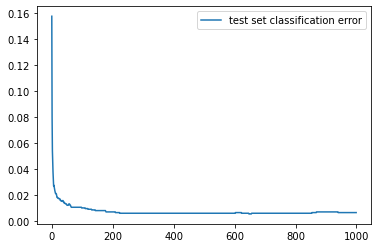

In [84]:
LR = 5e-2
epochs = 1000
hidden_layers = 1
hidden_size = 300
input_size = f0_train.shape[1]
NN1, error1 = train(f0_train, f1_train, f0_test, f1_test, epochs, LR, input_size, hidden_layers, hidden_size, criterion = 'exp')

Epoch: 1, Loss: 1.3771389, Test Error: 0.1126, Train Error: 0.1244
Epoch: 2, Loss: 1.3098425, Test Error: 0.0374, Train Error: 0.0467
Epoch: 3, Loss: 1.2476822, Test Error: 0.0297, Train Error: 0.0383
Epoch: 4, Loss: 1.1854525, Test Error: 0.0271, Train Error: 0.0360
Epoch: 5, Loss: 1.1207534, Test Error: 0.0266, Train Error: 0.0352
Epoch: 6, Loss: 1.0528678, Test Error: 0.0256, Train Error: 0.0345
Epoch: 7, Loss: 0.9821807, Test Error: 0.0246, Train Error: 0.0334
Epoch: 8, Loss: 0.9099742, Test Error: 0.0235, Train Error: 0.0327
Epoch: 9, Loss: 0.8379825, Test Error: 0.0235, Train Error: 0.0318
Epoch: 10, Loss: 0.7681646, Test Error: 0.0230, Train Error: 0.0316
Epoch: 11, Loss: 0.7022116, Test Error: 0.0225, Train Error: 0.0314
Epoch: 12, Loss: 0.6413974, Test Error: 0.0220, Train Error: 0.0313
Epoch: 13, Loss: 0.5864194, Test Error: 0.0215, Train Error: 0.0306
Epoch: 14, Loss: 0.5374548, Test Error: 0.0205, Train Error: 0.0303
Epoch: 15, Loss: 0.4942806, Test Error: 0.0205, Train Err

Epoch: 122, Loss: 0.0840617, Test Error: 0.0092, Train Error: 0.0119
Epoch: 123, Loss: 0.0837412, Test Error: 0.0092, Train Error: 0.0118
Epoch: 124, Loss: 0.0834259, Test Error: 0.0092, Train Error: 0.0118
Epoch: 125, Loss: 0.0831156, Test Error: 0.0092, Train Error: 0.0116
Epoch: 126, Loss: 0.0828103, Test Error: 0.0092, Train Error: 0.0116
Epoch: 127, Loss: 0.0825097, Test Error: 0.0092, Train Error: 0.0116
Epoch: 128, Loss: 0.0822139, Test Error: 0.0092, Train Error: 0.0116
Epoch: 129, Loss: 0.0819226, Test Error: 0.0092, Train Error: 0.0116
Epoch: 130, Loss: 0.0816357, Test Error: 0.0092, Train Error: 0.0115
Epoch: 131, Loss: 0.0813532, Test Error: 0.0092, Train Error: 0.0114
Epoch: 132, Loss: 0.0810749, Test Error: 0.0092, Train Error: 0.0114
Epoch: 133, Loss: 0.0808007, Test Error: 0.0092, Train Error: 0.0114
Epoch: 134, Loss: 0.0805306, Test Error: 0.0092, Train Error: 0.0114
Epoch: 135, Loss: 0.0802643, Test Error: 0.0092, Train Error: 0.0113
Epoch: 136, Loss: 0.0800019, Test 

Epoch: 241, Loss: 0.0641638, Test Error: 0.0082, Train Error: 0.0094
Epoch: 242, Loss: 0.0640743, Test Error: 0.0082, Train Error: 0.0094
Epoch: 243, Loss: 0.0639853, Test Error: 0.0082, Train Error: 0.0093
Epoch: 244, Loss: 0.0638969, Test Error: 0.0082, Train Error: 0.0093
Epoch: 245, Loss: 0.0638092, Test Error: 0.0082, Train Error: 0.0093
Epoch: 246, Loss: 0.0637221, Test Error: 0.0082, Train Error: 0.0093
Epoch: 247, Loss: 0.0636356, Test Error: 0.0082, Train Error: 0.0093
Epoch: 248, Loss: 0.0635497, Test Error: 0.0082, Train Error: 0.0093
Epoch: 249, Loss: 0.0634643, Test Error: 0.0077, Train Error: 0.0092
Epoch: 250, Loss: 0.0633795, Test Error: 0.0077, Train Error: 0.0092
Epoch: 251, Loss: 0.0632953, Test Error: 0.0077, Train Error: 0.0092
Epoch: 252, Loss: 0.0632117, Test Error: 0.0077, Train Error: 0.0092
Epoch: 253, Loss: 0.0631286, Test Error: 0.0077, Train Error: 0.0092
Epoch: 254, Loss: 0.0630461, Test Error: 0.0077, Train Error: 0.0092
Epoch: 255, Loss: 0.0629641, Test 

Epoch: 360, Loss: 0.0564683, Test Error: 0.0067, Train Error: 0.0083
Epoch: 361, Loss: 0.0564206, Test Error: 0.0067, Train Error: 0.0083
Epoch: 362, Loss: 0.0563730, Test Error: 0.0067, Train Error: 0.0082
Epoch: 363, Loss: 0.0563257, Test Error: 0.0067, Train Error: 0.0082
Epoch: 364, Loss: 0.0562785, Test Error: 0.0067, Train Error: 0.0082
Epoch: 365, Loss: 0.0562315, Test Error: 0.0067, Train Error: 0.0082
Epoch: 366, Loss: 0.0561848, Test Error: 0.0067, Train Error: 0.0082
Epoch: 367, Loss: 0.0561381, Test Error: 0.0067, Train Error: 0.0082
Epoch: 368, Loss: 0.0560917, Test Error: 0.0067, Train Error: 0.0082
Epoch: 369, Loss: 0.0560454, Test Error: 0.0067, Train Error: 0.0082
Epoch: 370, Loss: 0.0559994, Test Error: 0.0067, Train Error: 0.0082
Epoch: 371, Loss: 0.0559535, Test Error: 0.0067, Train Error: 0.0082
Epoch: 372, Loss: 0.0559078, Test Error: 0.0067, Train Error: 0.0082
Epoch: 373, Loss: 0.0558624, Test Error: 0.0067, Train Error: 0.0081
Epoch: 374, Loss: 0.0558170, Test 

Epoch: 479, Loss: 0.0517858, Test Error: 0.0061, Train Error: 0.0072
Epoch: 480, Loss: 0.0517531, Test Error: 0.0061, Train Error: 0.0072
Epoch: 481, Loss: 0.0517205, Test Error: 0.0061, Train Error: 0.0072
Epoch: 482, Loss: 0.0516880, Test Error: 0.0061, Train Error: 0.0072
Epoch: 483, Loss: 0.0516557, Test Error: 0.0061, Train Error: 0.0072
Epoch: 484, Loss: 0.0516233, Test Error: 0.0061, Train Error: 0.0072
Epoch: 485, Loss: 0.0515911, Test Error: 0.0061, Train Error: 0.0072
Epoch: 486, Loss: 0.0515590, Test Error: 0.0061, Train Error: 0.0072
Epoch: 487, Loss: 0.0515269, Test Error: 0.0061, Train Error: 0.0072
Epoch: 488, Loss: 0.0514950, Test Error: 0.0061, Train Error: 0.0072
Epoch: 489, Loss: 0.0514632, Test Error: 0.0061, Train Error: 0.0072
Epoch: 490, Loss: 0.0514313, Test Error: 0.0061, Train Error: 0.0072
Epoch: 491, Loss: 0.0513996, Test Error: 0.0061, Train Error: 0.0072
Epoch: 492, Loss: 0.0513680, Test Error: 0.0061, Train Error: 0.0072
Epoch: 493, Loss: 0.0513364, Test 

Epoch: 598, Loss: 0.0483962, Test Error: 0.0061, Train Error: 0.0068
Epoch: 599, Loss: 0.0483712, Test Error: 0.0061, Train Error: 0.0068
Epoch: 600, Loss: 0.0483462, Test Error: 0.0061, Train Error: 0.0068
Epoch: 601, Loss: 0.0483213, Test Error: 0.0061, Train Error: 0.0068
Epoch: 602, Loss: 0.0482964, Test Error: 0.0061, Train Error: 0.0068
Epoch: 603, Loss: 0.0482717, Test Error: 0.0061, Train Error: 0.0068
Epoch: 604, Loss: 0.0482469, Test Error: 0.0061, Train Error: 0.0068
Epoch: 605, Loss: 0.0482223, Test Error: 0.0061, Train Error: 0.0068
Epoch: 606, Loss: 0.0481976, Test Error: 0.0061, Train Error: 0.0068
Epoch: 607, Loss: 0.0481730, Test Error: 0.0061, Train Error: 0.0068
Epoch: 608, Loss: 0.0481485, Test Error: 0.0061, Train Error: 0.0068
Epoch: 609, Loss: 0.0481239, Test Error: 0.0061, Train Error: 0.0068
Epoch: 610, Loss: 0.0480995, Test Error: 0.0061, Train Error: 0.0068
Epoch: 611, Loss: 0.0480751, Test Error: 0.0061, Train Error: 0.0068
Epoch: 612, Loss: 0.0480508, Test 

Epoch: 717, Loss: 0.0457055, Test Error: 0.0067, Train Error: 0.0063
Epoch: 718, Loss: 0.0456850, Test Error: 0.0067, Train Error: 0.0063
Epoch: 719, Loss: 0.0456646, Test Error: 0.0067, Train Error: 0.0063
Epoch: 720, Loss: 0.0456441, Test Error: 0.0067, Train Error: 0.0063
Epoch: 721, Loss: 0.0456237, Test Error: 0.0067, Train Error: 0.0063
Epoch: 722, Loss: 0.0456034, Test Error: 0.0067, Train Error: 0.0063
Epoch: 723, Loss: 0.0455830, Test Error: 0.0067, Train Error: 0.0063
Epoch: 724, Loss: 0.0455627, Test Error: 0.0067, Train Error: 0.0063
Epoch: 725, Loss: 0.0455424, Test Error: 0.0067, Train Error: 0.0063
Epoch: 726, Loss: 0.0455221, Test Error: 0.0067, Train Error: 0.0063
Epoch: 727, Loss: 0.0455019, Test Error: 0.0067, Train Error: 0.0063
Epoch: 728, Loss: 0.0454817, Test Error: 0.0067, Train Error: 0.0063
Epoch: 729, Loss: 0.0454616, Test Error: 0.0067, Train Error: 0.0063
Epoch: 730, Loss: 0.0454414, Test Error: 0.0067, Train Error: 0.0063
Epoch: 731, Loss: 0.0454212, Test 

Epoch: 836, Loss: 0.0434562, Test Error: 0.0067, Train Error: 0.0060
Epoch: 837, Loss: 0.0434389, Test Error: 0.0067, Train Error: 0.0059
Epoch: 838, Loss: 0.0434216, Test Error: 0.0067, Train Error: 0.0059
Epoch: 839, Loss: 0.0434043, Test Error: 0.0067, Train Error: 0.0059
Epoch: 840, Loss: 0.0433870, Test Error: 0.0067, Train Error: 0.0059
Epoch: 841, Loss: 0.0433698, Test Error: 0.0067, Train Error: 0.0059
Epoch: 842, Loss: 0.0433526, Test Error: 0.0067, Train Error: 0.0059
Epoch: 843, Loss: 0.0433353, Test Error: 0.0067, Train Error: 0.0059
Epoch: 844, Loss: 0.0433181, Test Error: 0.0067, Train Error: 0.0059
Epoch: 845, Loss: 0.0433010, Test Error: 0.0067, Train Error: 0.0059
Epoch: 846, Loss: 0.0432839, Test Error: 0.0067, Train Error: 0.0059
Epoch: 847, Loss: 0.0432668, Test Error: 0.0067, Train Error: 0.0059
Epoch: 848, Loss: 0.0432498, Test Error: 0.0067, Train Error: 0.0059
Epoch: 849, Loss: 0.0432327, Test Error: 0.0067, Train Error: 0.0059
Epoch: 850, Loss: 0.0432157, Test 

Epoch: 955, Loss: 0.0415324, Test Error: 0.0061, Train Error: 0.0057
Epoch: 956, Loss: 0.0415174, Test Error: 0.0061, Train Error: 0.0057
Epoch: 957, Loss: 0.0415024, Test Error: 0.0061, Train Error: 0.0057
Epoch: 958, Loss: 0.0414874, Test Error: 0.0061, Train Error: 0.0057
Epoch: 959, Loss: 0.0414725, Test Error: 0.0061, Train Error: 0.0057
Epoch: 960, Loss: 0.0414576, Test Error: 0.0061, Train Error: 0.0057
Epoch: 961, Loss: 0.0414426, Test Error: 0.0061, Train Error: 0.0057
Epoch: 962, Loss: 0.0414277, Test Error: 0.0061, Train Error: 0.0057
Epoch: 963, Loss: 0.0414128, Test Error: 0.0061, Train Error: 0.0057
Epoch: 964, Loss: 0.0413979, Test Error: 0.0061, Train Error: 0.0057
Epoch: 965, Loss: 0.0413831, Test Error: 0.0061, Train Error: 0.0057
Epoch: 966, Loss: 0.0413682, Test Error: 0.0061, Train Error: 0.0057
Epoch: 967, Loss: 0.0413534, Test Error: 0.0061, Train Error: 0.0057
Epoch: 968, Loss: 0.0413385, Test Error: 0.0061, Train Error: 0.0057
Epoch: 969, Loss: 0.0413237, Test 

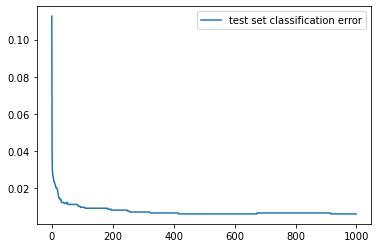

In [85]:
LR = 5e-2
epochs = 1000
hidden_layers = 1
hidden_size = 300
input_size = f0_train.shape[1]
NN2, error2 = train(f0_train, f1_train, f0_test, f1_test, epochs, LR, input_size, hidden_layers, hidden_size, criterion = 'BCE')

Epoch: 1, Loss: 2.0942881, Test Error: 0.4985, Train Error: 0.4969
Epoch: 2, Loss: 1.7765617, Test Error: 0.4985, Train Error: 0.4969
Epoch: 3, Loss: 1.4551915, Test Error: 0.4985, Train Error: 0.4969
Epoch: 4, Loss: 1.0312853, Test Error: 0.4191, Train Error: 0.4310
Epoch: 5, Loss: 0.5508911, Test Error: 0.0983, Train Error: 0.1046
Epoch: 6, Loss: 0.3892478, Test Error: 0.2758, Train Error: 0.2932
Epoch: 7, Loss: 0.3260927, Test Error: 0.0573, Train Error: 0.0645
Epoch: 8, Loss: 0.2708504, Test Error: 0.1341, Train Error: 0.1347
Epoch: 9, Loss: 0.2090960, Test Error: 0.0829, Train Error: 0.0888
Epoch: 10, Loss: 0.1879770, Test Error: 0.0839, Train Error: 0.0902
Epoch: 11, Loss: 0.1756016, Test Error: 0.0778, Train Error: 0.0820
Epoch: 12, Loss: 0.1658296, Test Error: 0.0711, Train Error: 0.0773
Epoch: 13, Loss: 0.1575190, Test Error: 0.0670, Train Error: 0.0734
Epoch: 14, Loss: 0.1502368, Test Error: 0.0650, Train Error: 0.0698
Epoch: 15, Loss: 0.1436710, Test Error: 0.0619, Train Err

Epoch: 122, Loss: 0.0523515, Test Error: 0.0246, Train Error: 0.0210
Epoch: 123, Loss: 0.0522109, Test Error: 0.0251, Train Error: 0.0211
Epoch: 124, Loss: 0.0520749, Test Error: 0.0251, Train Error: 0.0210
Epoch: 125, Loss: 0.0519404, Test Error: 0.0251, Train Error: 0.0210
Epoch: 126, Loss: 0.0518059, Test Error: 0.0246, Train Error: 0.0209
Epoch: 127, Loss: 0.0516730, Test Error: 0.0246, Train Error: 0.0211
Epoch: 128, Loss: 0.0515416, Test Error: 0.0241, Train Error: 0.0208
Epoch: 129, Loss: 0.0514120, Test Error: 0.0235, Train Error: 0.0207
Epoch: 130, Loss: 0.0512850, Test Error: 0.0235, Train Error: 0.0206
Epoch: 131, Loss: 0.0511586, Test Error: 0.0235, Train Error: 0.0208
Epoch: 132, Loss: 0.0510337, Test Error: 0.0235, Train Error: 0.0203
Epoch: 133, Loss: 0.0509110, Test Error: 0.0241, Train Error: 0.0206
Epoch: 134, Loss: 0.0507915, Test Error: 0.0235, Train Error: 0.0206
Epoch: 135, Loss: 0.0506728, Test Error: 0.0235, Train Error: 0.0205
Epoch: 136, Loss: 0.0505543, Test 

Epoch: 241, Loss: 0.0416972, Test Error: 0.0205, Train Error: 0.0166
Epoch: 242, Loss: 0.0416404, Test Error: 0.0205, Train Error: 0.0164
Epoch: 243, Loss: 0.0415837, Test Error: 0.0205, Train Error: 0.0165
Epoch: 244, Loss: 0.0415280, Test Error: 0.0200, Train Error: 0.0165
Epoch: 245, Loss: 0.0414727, Test Error: 0.0200, Train Error: 0.0162
Epoch: 246, Loss: 0.0414177, Test Error: 0.0200, Train Error: 0.0164
Epoch: 247, Loss: 0.0413627, Test Error: 0.0200, Train Error: 0.0163
Epoch: 248, Loss: 0.0413075, Test Error: 0.0200, Train Error: 0.0164
Epoch: 249, Loss: 0.0412522, Test Error: 0.0200, Train Error: 0.0162
Epoch: 250, Loss: 0.0411971, Test Error: 0.0200, Train Error: 0.0165
Epoch: 251, Loss: 0.0411422, Test Error: 0.0200, Train Error: 0.0163
Epoch: 252, Loss: 0.0410872, Test Error: 0.0200, Train Error: 0.0163
Epoch: 253, Loss: 0.0410327, Test Error: 0.0200, Train Error: 0.0161
Epoch: 254, Loss: 0.0409798, Test Error: 0.0200, Train Error: 0.0160
Epoch: 255, Loss: 0.0409281, Test 

Epoch: 360, Loss: 0.0367375, Test Error: 0.0179, Train Error: 0.0140
Epoch: 361, Loss: 0.0367034, Test Error: 0.0179, Train Error: 0.0136
Epoch: 362, Loss: 0.0366690, Test Error: 0.0179, Train Error: 0.0139
Epoch: 363, Loss: 0.0366355, Test Error: 0.0179, Train Error: 0.0136
Epoch: 364, Loss: 0.0366021, Test Error: 0.0179, Train Error: 0.0138
Epoch: 365, Loss: 0.0365682, Test Error: 0.0179, Train Error: 0.0138
Epoch: 366, Loss: 0.0365346, Test Error: 0.0179, Train Error: 0.0138
Epoch: 367, Loss: 0.0365011, Test Error: 0.0179, Train Error: 0.0138
Epoch: 368, Loss: 0.0364677, Test Error: 0.0179, Train Error: 0.0137
Epoch: 369, Loss: 0.0364344, Test Error: 0.0179, Train Error: 0.0137
Epoch: 370, Loss: 0.0364011, Test Error: 0.0179, Train Error: 0.0137
Epoch: 371, Loss: 0.0363677, Test Error: 0.0179, Train Error: 0.0137
Epoch: 372, Loss: 0.0363344, Test Error: 0.0179, Train Error: 0.0135
Epoch: 373, Loss: 0.0363012, Test Error: 0.0179, Train Error: 0.0138
Epoch: 374, Loss: 0.0362687, Test 

Epoch: 479, Loss: 0.0331064, Test Error: 0.0164, Train Error: 0.0123
Epoch: 480, Loss: 0.0330802, Test Error: 0.0164, Train Error: 0.0127
Epoch: 481, Loss: 0.0330544, Test Error: 0.0164, Train Error: 0.0121
Epoch: 482, Loss: 0.0330297, Test Error: 0.0164, Train Error: 0.0127
Epoch: 483, Loss: 0.0330043, Test Error: 0.0164, Train Error: 0.0123
Epoch: 484, Loss: 0.0329778, Test Error: 0.0164, Train Error: 0.0127
Epoch: 485, Loss: 0.0329527, Test Error: 0.0164, Train Error: 0.0121
Epoch: 486, Loss: 0.0329283, Test Error: 0.0164, Train Error: 0.0127
Epoch: 487, Loss: 0.0329037, Test Error: 0.0164, Train Error: 0.0123
Epoch: 488, Loss: 0.0328756, Test Error: 0.0164, Train Error: 0.0123
Epoch: 489, Loss: 0.0328501, Test Error: 0.0164, Train Error: 0.0124
Epoch: 490, Loss: 0.0328246, Test Error: 0.0164, Train Error: 0.0125
Epoch: 491, Loss: 0.0327995, Test Error: 0.0164, Train Error: 0.0123
Epoch: 492, Loss: 0.0327739, Test Error: 0.0164, Train Error: 0.0126
Epoch: 493, Loss: 0.0327489, Test 

Epoch: 598, Loss: 0.0302148, Test Error: 0.0154, Train Error: 0.0115
Epoch: 599, Loss: 0.0301925, Test Error: 0.0154, Train Error: 0.0118
Epoch: 600, Loss: 0.0301682, Test Error: 0.0154, Train Error: 0.0116
Epoch: 601, Loss: 0.0301448, Test Error: 0.0154, Train Error: 0.0116
Epoch: 602, Loss: 0.0301207, Test Error: 0.0154, Train Error: 0.0118
Epoch: 603, Loss: 0.0300974, Test Error: 0.0154, Train Error: 0.0114
Epoch: 604, Loss: 0.0300749, Test Error: 0.0154, Train Error: 0.0118
Epoch: 605, Loss: 0.0300507, Test Error: 0.0148, Train Error: 0.0114
Epoch: 606, Loss: 0.0300282, Test Error: 0.0154, Train Error: 0.0118
Epoch: 607, Loss: 0.0300048, Test Error: 0.0148, Train Error: 0.0115
Epoch: 608, Loss: 0.0299816, Test Error: 0.0154, Train Error: 0.0118
Epoch: 609, Loss: 0.0299585, Test Error: 0.0148, Train Error: 0.0115
Epoch: 610, Loss: 0.0299355, Test Error: 0.0154, Train Error: 0.0118
Epoch: 611, Loss: 0.0299133, Test Error: 0.0148, Train Error: 0.0112
Epoch: 612, Loss: 0.0298920, Test 

Epoch: 717, Loss: 0.0275612, Test Error: 0.0128, Train Error: 0.0108
Epoch: 718, Loss: 0.0275390, Test Error: 0.0128, Train Error: 0.0110
Epoch: 719, Loss: 0.0275178, Test Error: 0.0128, Train Error: 0.0109
Epoch: 720, Loss: 0.0274958, Test Error: 0.0128, Train Error: 0.0109
Epoch: 721, Loss: 0.0274744, Test Error: 0.0128, Train Error: 0.0108
Epoch: 722, Loss: 0.0274532, Test Error: 0.0128, Train Error: 0.0110
Epoch: 723, Loss: 0.0274320, Test Error: 0.0128, Train Error: 0.0106
Epoch: 724, Loss: 0.0274122, Test Error: 0.0128, Train Error: 0.0111
Epoch: 725, Loss: 0.0273920, Test Error: 0.0128, Train Error: 0.0108
Epoch: 726, Loss: 0.0273686, Test Error: 0.0128, Train Error: 0.0109
Epoch: 727, Loss: 0.0273473, Test Error: 0.0128, Train Error: 0.0108
Epoch: 728, Loss: 0.0273254, Test Error: 0.0128, Train Error: 0.0110
Epoch: 729, Loss: 0.0273044, Test Error: 0.0128, Train Error: 0.0108
Epoch: 730, Loss: 0.0272835, Test Error: 0.0128, Train Error: 0.0111
Epoch: 731, Loss: 0.0272642, Test 

Epoch: 836, Loss: 0.0250937, Test Error: 0.0107, Train Error: 0.0104
Epoch: 837, Loss: 0.0250727, Test Error: 0.0107, Train Error: 0.0098
Epoch: 838, Loss: 0.0250531, Test Error: 0.0107, Train Error: 0.0107
Epoch: 839, Loss: 0.0250365, Test Error: 0.0102, Train Error: 0.0099
Epoch: 840, Loss: 0.0250110, Test Error: 0.0107, Train Error: 0.0104
Epoch: 841, Loss: 0.0249904, Test Error: 0.0102, Train Error: 0.0099
Epoch: 842, Loss: 0.0249692, Test Error: 0.0107, Train Error: 0.0106
Epoch: 843, Loss: 0.0249495, Test Error: 0.0102, Train Error: 0.0096
Epoch: 844, Loss: 0.0249305, Test Error: 0.0107, Train Error: 0.0108
Epoch: 845, Loss: 0.0249208, Test Error: 0.0102, Train Error: 0.0099
Epoch: 846, Loss: 0.0248861, Test Error: 0.0102, Train Error: 0.0103
Epoch: 847, Loss: 0.0248655, Test Error: 0.0102, Train Error: 0.0099
Epoch: 848, Loss: 0.0248450, Test Error: 0.0102, Train Error: 0.0107
Epoch: 849, Loss: 0.0248247, Test Error: 0.0102, Train Error: 0.0094
Epoch: 850, Loss: 0.0248099, Test 

Epoch: 955, Loss: 0.0227386, Test Error: 0.0102, Train Error: 0.0093
Epoch: 956, Loss: 0.0227179, Test Error: 0.0102, Train Error: 0.0095
Epoch: 957, Loss: 0.0226987, Test Error: 0.0102, Train Error: 0.0093
Epoch: 958, Loss: 0.0226792, Test Error: 0.0102, Train Error: 0.0096
Epoch: 959, Loss: 0.0226604, Test Error: 0.0102, Train Error: 0.0089
Epoch: 960, Loss: 0.0226433, Test Error: 0.0102, Train Error: 0.0102
Epoch: 961, Loss: 0.0226325, Test Error: 0.0102, Train Error: 0.0087
Epoch: 962, Loss: 0.0226110, Test Error: 0.0102, Train Error: 0.0100
Epoch: 963, Loss: 0.0225941, Test Error: 0.0102, Train Error: 0.0087
Epoch: 964, Loss: 0.0225691, Test Error: 0.0102, Train Error: 0.0101
Epoch: 965, Loss: 0.0225558, Test Error: 0.0102, Train Error: 0.0089
Epoch: 966, Loss: 0.0225287, Test Error: 0.0102, Train Error: 0.0099
Epoch: 967, Loss: 0.0225136, Test Error: 0.0102, Train Error: 0.0093
Epoch: 968, Loss: 0.0224894, Test Error: 0.0102, Train Error: 0.0095
Epoch: 969, Loss: 0.0224704, Test 

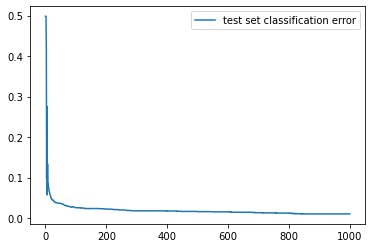

In [86]:
LR = 5e-2
epochs = 1000
hidden_layers = 1
hidden_size = 300
input_size = f0_train.shape[1]
NN3, error3 = train(f0_train, f1_train, f0_test, f1_test, epochs, LR, input_size, hidden_layers, hidden_size, criterion = 'hinge')

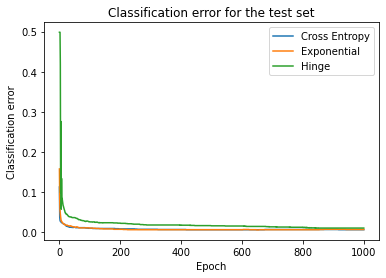

In [88]:
fig, ax = plt.subplots()

ax.plot(error2, label='Cross Entropy')
ax.plot(error1, label='Exponential')
ax.plot(error3, label='Hinge')
ax.set(xlabel='Epoch', ylabel='Classification error',
       title='Classification error for the test set')
ax.legend()

In [110]:
threshold = len(f0_train)/len(f1_train)

In [105]:
threshold1 = np.log(threshold)
u1 = NN1(f0_test,'exp')
u2 = NN1(f1_test,'exp')
print(f' TP:{torch.sum(u2>threshold1)}\n FP:{torch.sum(u2<threshold1)}\n TN:{torch.sum(u1<threshold1)}\n FN:{torch.sum(u1>threshold1)}')

 TP:964
 FP:10
 TN:977
 FN:3


In [132]:
threshold2 = threshold/(threshold+1)
u1 = NN2(f0_test,'BCE')
u2 = NN2(f1_test,'BCE')
print(f' TP:{torch.sum(u2>threshold2)}\n FP:{torch.sum(u2<threshold2)}\n TN:{torch.sum(u1<threshold2)}\n FN:{torch.sum(u1>threshold2)}')

 TP:966
 FP:8
 TN:976
 FN:4


In [111]:
threshold3 = np.sign(np.log(threshold))
u1 = NN3(f0_test,'hinge')
u2 = NN3(f1_test,'hinge')
print(f' TP:{torch.sum(u2>threshold3)}\n FP:{torch.sum(u2<threshold3)}\n TN:{torch.sum(u1<threshold3)}\n FN:{torch.sum(u1>threshold3)}')

 TP:957
 FP:17
 TN:977
 FN:3


In [133]:
(u2<threshold2).nonzero()

tensor([[ 39,   0],
        [121,   0],
        [164,   0],
        [223,   0],
        [277,   0],
        [349,   0],
        [389,   0],
        [467,   0]])

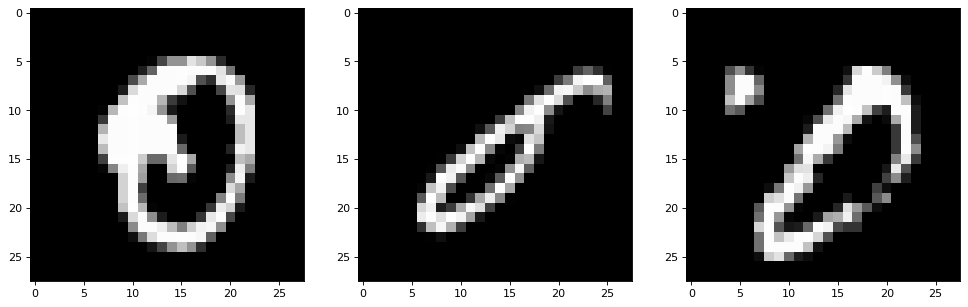

In [128]:
plt.figure(figsize=(15, 5), dpi=80) #figure size
for ind, i  in enumerate([449,634,942]):
    plt.subplot(1, 3, ind+1)
    plt.imshow(f0_test[i].reshape(28,28),cmap='gray')

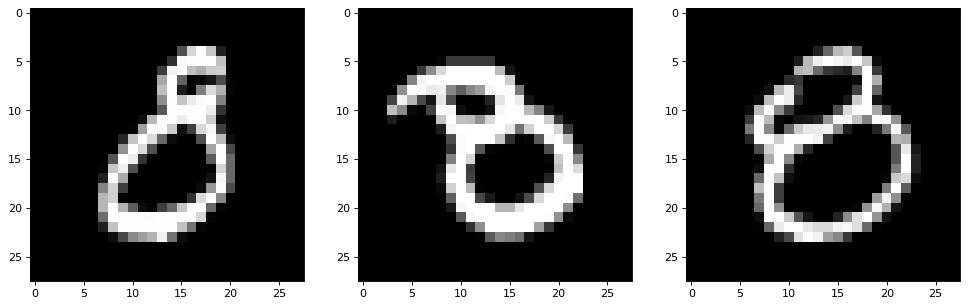

In [139]:
plt.figure(figsize=(15, 5), dpi=80) #figure size
for ind, i  in enumerate([467,121,164]):
    plt.subplot(1, 3, ind+1)
    plt.imshow(f1_test[i].reshape(28,28),cmap='gray')

In [141]:
print(f0_train.shape,f1_train.shape,f0_test.shape,f1_test.shape)

torch.Size([5923, 784]) torch.Size([5851, 784]) torch.Size([980, 784]) torch.Size([974, 784])
